	
# Разработка A/B-тестирования для нового алгоритма рекомендаций

Компания, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Будем работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

In [1]:
import pandas as pd 

In [2]:
# создаем дтафрейм с историческими данными о сессиях пользователей на период с 15 августа по 23 сентября 2025 года 
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

In [3]:
# расчитываем количество уникальных сессий для каждого пользователя 
sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending = False)

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

In [4]:
# выводим всю информацию о данных для одного пользователя 
sessions_history.query("user_id == '10E0DEFC1ABDBBE0'").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 115558 to 414743
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            10 non-null     object
 1   session_id         10 non-null     object
 2   session_date       10 non-null     object
 3   session_start_ts   10 non-null     object
 4   install_date       10 non-null     object
 5   session_number     10 non-null     int64 
 6   registration_flag  10 non-null     int64 
 7   page_counter       10 non-null     int64 
 8   region             10 non-null     object
 9   device             10 non-null     object
dtypes: int64(3), object(7)
memory usage: 880.0+ bytes


In [5]:
# выводим все данные по одному пользователю 
sessions_history.query("user_id == '10E0DEFC1ABDBBE0'").head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android


В каждом столбце всего 10 строк и ни в одном из них нет пропусков. Все типы данных распределены верно.

In [6]:
# рассчитаем число уникальных пользователей для каждого дня 
regist_fl_and_unuser_id = sessions_history.groupby('session_date').agg({'user_id' : 'nunique',
                                            'registration_flag' : 'sum'})

In [7]:
# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns 

<Figure size 1152x504 with 0 Axes>

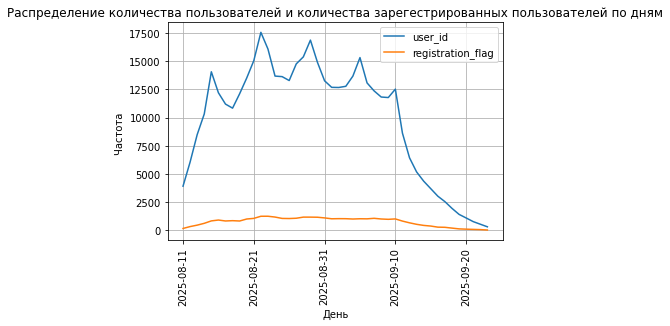

In [8]:
# строим линейный график 
plt.figure(figsize = (16, 7))
regist_fl_and_unuser_id.plot(kind = 'line',
                            rot = 90)
plt.title('Распределение количества пользователей и количества зарегестрированных пользователей по дням')
plt.xlabel('День')
plt.ylabel('Частота ')
plt.grid()
plt.show() 

In [9]:
# считаем долю зарегистрированных пользователей от всех пользователей по дням 
regist = sessions_history.groupby('session_date')['registration_flag'].sum()
us = sessions_history.groupby('session_date')['user_id'].nunique()
reg_us = regist / us

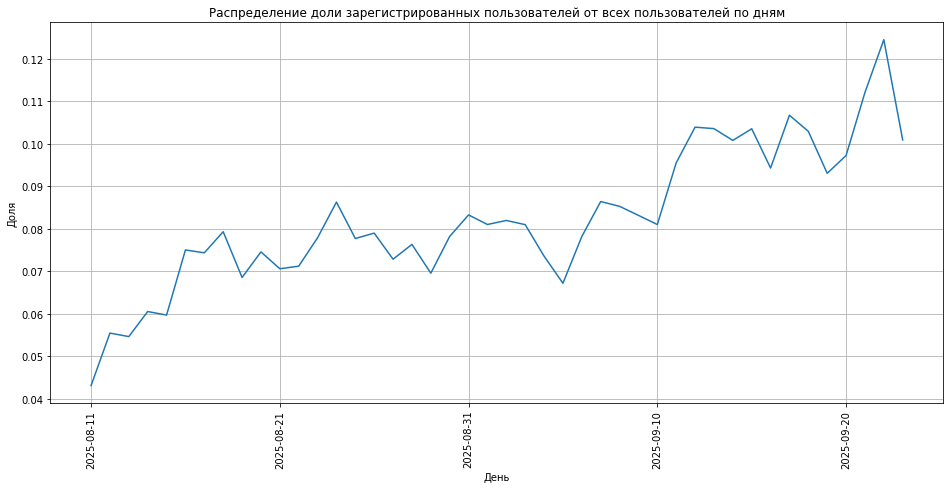

In [10]:
# строим линейный график 
plt.figure(figsize = (16, 7))
reg_us.plot(kind = 'line',
                            rot = 90)
plt.title('Распределение доли зарегистрированных пользователей от всех пользователей по дням')
plt.xlabel('День')
plt.ylabel('Доля')
plt.grid()
plt.show() 

In [11]:
# находим количество сессий для каждого значения количества просмотренных страниц 
sessia = sessions_history.groupby('page_counter')['session_id'].count()

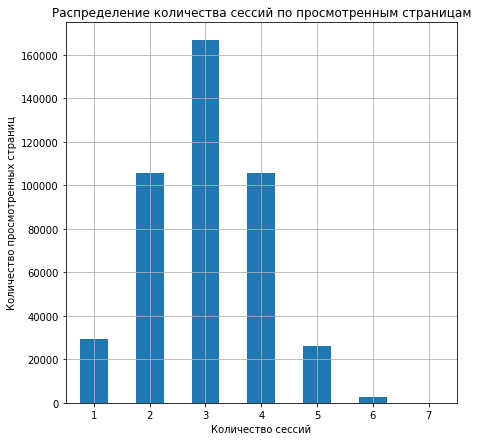

In [12]:
# строим столбчатую диаграмму 
plt.figure(figsize = (7, 7))
sessia.plot(kind = 'bar',
           rot = 0)
plt.title('Распределение количества сессий по просмотренным страницам')
plt.xlabel('Количество сессий')
plt.ylabel('Количество просмотренных страниц')
plt.grid()
plt.show() 

In [13]:
# создаем доп. столбец 
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

In [14]:
a_1 = sessions_history.groupby('session_date')['good_session'].sum()
a_2 = sessions_history.groupby('session_date')['session_id'].count()
all = (a_1 / a_2)*100

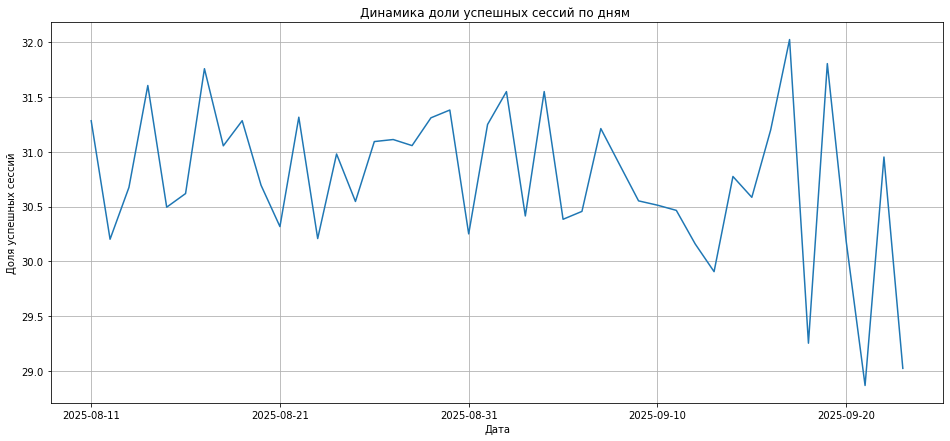

In [15]:
# строим линейную диаграмму 
plt.figure(figsize = (16, 7))
all.plot(kind = 'line',
           rot = 0)
plt.title('Динамика доли успешных сессий по дням ')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid()
plt.show() 

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки

In [16]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста


In [17]:
from math import *

# Среднее количество пользователей приложения в день по историческим данным
un_users_per_day = sessions_history.groupby('session_date')['user_id'].nunique()

num_day = len(un_users_per_day)

avg_daily_users = round(un_users_per_day.mean())


# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size*2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей


In [18]:
# создаем новый датафрейм, в котором отображаются исторические данные за 1 день проведения теста 
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

In [19]:
# рассчитываем количество уникальных пользователей в каждой тестовой группе 
test_group = sessions_test_part.groupby('test_group')['user_id'].nunique()

In [20]:
# находим процентное соотношение между группами
100 * sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique() / sessions_test_part['user_id'].nunique(),100 * sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique() / sessions_test_part['user_id'].nunique()

(50.18688413183826, 49.81311586816174)

In [21]:
# рассчитываем процентную разницу между группами 
perc = round(100 * abs(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique() - sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()) / sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique(), 2)
perc

0.74

In [22]:
# делаем метки для диаграммы 
labels = test_group.index
sizes = test_group.values

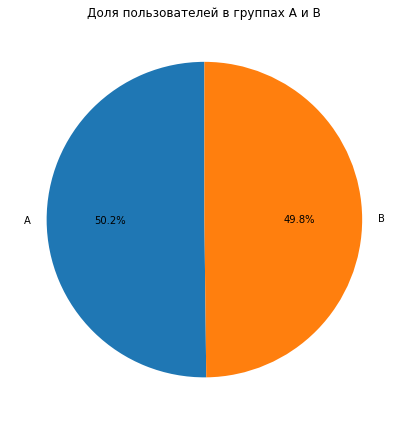

In [23]:
# создаем диаграмму 
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Доля пользователей в группах A и B')
plt.tight_layout()
plt.show()

#### 3.2. Проверка пересечений пользователей

In [24]:
# находим пользователей, которые попали в 2 группы 
group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']
intersection = list(set(group_a) & set(group_b))
intersection

[]

Пользователи, которые встречаются одновременно в группах А и В отсутствуют

#### 3.3. Равномерность разделения пользователей по устройствам


In [25]:
# находим количество каждого типа устройства в каждой тестовой гуппе 
device_group = sessions_test_part.groupby(['test_group','device']).nunique().reset_index()
device_group

,test_group,device,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region
0,A,Android,656,656,1,651,1,1,2,5,3
1,A,Mac,156,160,1,159,2,5,2,5,3
2,A,PC,369,379,1,376,3,7,2,6,3
3,A,iPhone,296,307,1,302,2,5,2,6,3
4,B,Android,668,723,1,722,7,7,2,7,3
5,B,Mac,148,197,1,195,7,7,2,7,3
6,B,PC,381,402,1,400,5,6,2,7,3
7,B,iPhone,269,306,1,306,6,7,2,7,3


In [26]:
# отделяем тестовую группу А от общей 
device_group_A = device_group.query('test_group == "A"')
device_group_A

,test_group,device,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region
0,A,Android,656,656,1,651,1,1,2,5,3
1,A,Mac,156,160,1,159,2,5,2,5,3
2,A,PC,369,379,1,376,3,7,2,6,3
3,A,iPhone,296,307,1,302,2,5,2,6,3


Text(0.5, 1.0, 'Доля каждого типа устройства для пользователей из группы A')

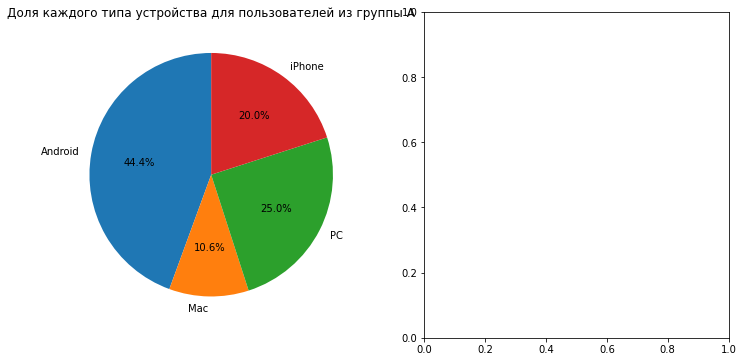

In [27]:
# Построение диаграммы для группы A
labels_a = device_group_A['device']
sizes_a = device_group_A['user_id']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].pie(sizes_a, labels=labels_a, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Доля каждого типа устройства для пользователей из группы A')

In [28]:
# отделяем тестовую руппу В от общей  
device_group_B = device_group.query('test_group == "B"')
device_group_B

,test_group,device,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region
4,B,Android,668,723,1,722,7,7,2,7,3
5,B,Mac,148,197,1,195,7,7,2,7,3
6,B,PC,381,402,1,400,5,6,2,7,3
7,B,iPhone,269,306,1,306,6,7,2,7,3


Text(0.5, 1.0, 'Доля каждого типа устройства для пользователей из группы B')

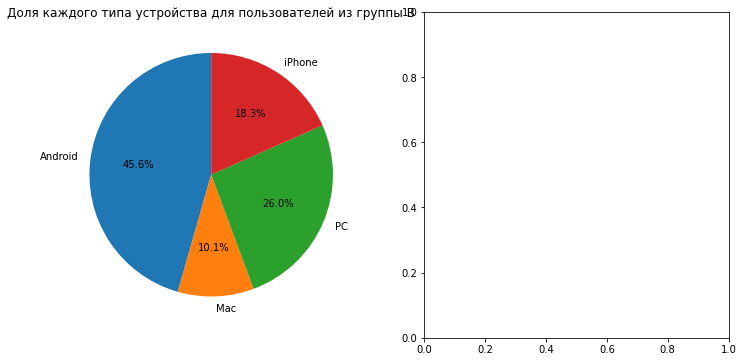

In [29]:
# Построение диаграммы для группы B
labels_b = device_group_B['device']
sizes_b = device_group_B['user_id']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].pie(sizes_b, labels=labels_b, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Доля каждого типа устройства для пользователей из группы B')

#### 3.4. Равномерность распределения пользователей по регионам

In [30]:
# находим количество регионов пользователей для каждой группы 
region_group = sessions_test_part.groupby(['test_group','region']).nunique().reset_index()
region_group

,test_group,region,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,device
0,A,CIS,644,656,1,649,3,5,2,6,4
1,A,EU,224,233,1,232,3,7,2,5,4
2,A,MENA,609,613,1,610,3,4,2,6,4
3,B,CIS,645,645,1,642,1,1,2,7,4
4,B,EU,217,220,1,219,2,4,2,7,4
5,B,MENA,604,763,1,758,7,7,2,7,4


In [31]:
# отдеяем группу А от общей 
region_group_A =region_group.query('test_group == "A"')
region_group_A

,test_group,region,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,device
0,A,CIS,644,656,1,649,3,5,2,6,4
1,A,EU,224,233,1,232,3,7,2,5,4
2,A,MENA,609,613,1,610,3,4,2,6,4


Text(0.5, 1.0, 'Доля каждого региона для пользователей из группы A')

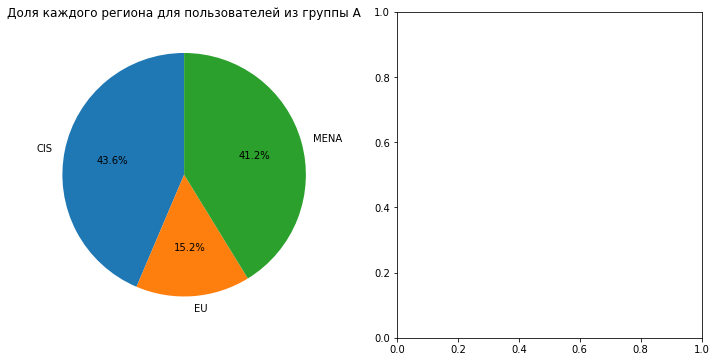

In [32]:
# Построение диаграммы для группы A
labels_a = region_group_A['region']
sizes_a = region_group_A['user_id']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].pie(sizes_a, labels=labels_a, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Доля каждого региона для пользователей из группы A')

In [33]:
# отделяем группы В от общей 
region_group_B =region_group.query('test_group == "B"')
region_group_B

,test_group,region,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,device
3,B,CIS,645,645,1,642,1,1,2,7,4
4,B,EU,217,220,1,219,2,4,2,7,4
5,B,MENA,604,763,1,758,7,7,2,7,4


Text(0.5, 1.0, 'Доля каждого региона для пользователей из группы B')

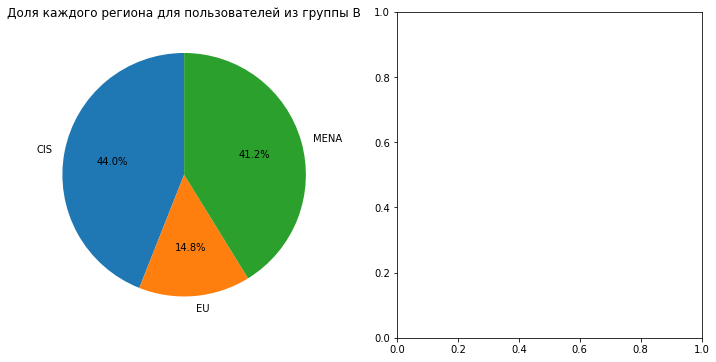

In [34]:
# Построение диаграммы для группы A
labels_a = region_group_B['region']
sizes_a = region_group_B['user_id']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].pie(sizes_a, labels=labels_a, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Доля каждого региона для пользователей из группы B')

#### 3.5. Вывод после проверки A/B-теста

- Размер выборки достаточный для проведения корректного тестирования;
- Различие между двумя группами в количестве пользователей было обнаружено, но незначительное, что не повлияет на результаты тестирования;
- Также в выборке отсутсвуют пересечения пользователей и она является независимой; 
- Распределение пользователей по устройствам является достаточно равномерным, также, как и по регионам. Но стоит отметить, что незначительные различия между группами присутствуют. 

А/В тестирование проходит корректно без каких-либо нарушений. 

### 4. Проверка результатов A/B-теста


#### 4.1. Получение результатов теста и подсчёт основной метрики


In [35]:
# создаем новый датафрейм
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

In [36]:
# создаем доп. столбец 
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

#### 4.2. Проверка корректности результатов теста

Формулируем гипотезы: 
- H₀ (нулевая гипотеза) - количество уникальных дневных сессий не различается между тестовой и контрольными группами, 
- Н₁(альтернативная гипотеза) - количество уникальных дневных сессий различается между тестовой и контрольными группами 

In [37]:
# считаем количество уникальных сессий для каждого дня и обеих тестовых групп
session_per_day = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique()

In [38]:
s_p_d = session_per_day.reset_index().pivot(index = 'session_date', columns = 'test_group', values = 'session_id')
s_p_d

test_group,A,B
session_date,,
2025-10-14,1502,1628
2025-10-15,2235,2283
2025-10-16,3280,3241
2025-10-17,4089,4054
2025-10-18,5013,5059
2025-10-19,6535,6779
2025-10-20,5837,6089
2025-10-21,3927,3981
2025-10-22,3083,3111


In [39]:
from scipy import stats as st
import numpy as np

In [40]:
# формируем метрику для каждой группы 
group_1 = s_p_d["A"]
group_2 = s_p_d["B"]

In [41]:
# проводим т-тест
alpha = 0.05 
results = st.ttest_ind(
    group_1,
    group_2,
    equal_var = False,
    alternative= 'two-sided'
)
print('pvalue:',round(results.pvalue, 2))
if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу. Количество уникальных дневных сессий различается между тестовой и контрольными группами')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Количество уникальных дневных сессий не различается между тестовой и контрольными группами')

pvalue: 0.94
Не получилось отвергнуть нулевую гипотезу. Количество уникальных дневных сессий не различается между тестовой и контрольными группами


#### 4.3. Сравнение доли успешных сессий

In [42]:
# Рассчитываем долю успешных сессий для каждой группы
perc_good_session = sessions_test.groupby('test_group')['good_session'].mean().reset_index(name = 'perc')
perc_good_session

,test_group,perc
0,A,0.307723
1,B,0.318290


In [43]:
diff = round(sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean() - sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean(), 2)
diff

0.01

In [44]:
print(f" Разница метрики долей упешных сессий между выборками А и В = {diff}")

 Разница метрики долей упешных сессий между выборками А и В = 0.01


#### 4.4. Насколько статистически значимо изменение ключевой метрики


In [45]:
# рассчитаем количество сессий 
n_a = sessions_test[sessions_test['test_group'] == 'A'].shape[0]
n_b = sessions_test[sessions_test['test_group'] == 'B'].shape[0]
n_a, n_b

(49551, 50454)

In [46]:
# рассчитаем количество успешных сессий 
m_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
m_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
m_a, m_b

(15248, 16059)

In [47]:
# расчитываем доли успехов для каждой группы 
p_a, p_b = m_a / n_a, m_b / n_b

In [48]:
# используем Z-тест 
from statsmodels.stats.proportion import proportions_ztest
alpha = 0.05
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative = 'two-sided')
p_value_ztest
if p_value_ztest > alpha:
    print(f'p_value = {p_value_ztest}. Изменение в доле успешных сессий не является статистически значимым.')
else:
    print(f'p_value = {p_value_ztest}. Изменение в доле успешных сессий статистически значимо.')

p_value = 0.0003149479976072246. Изменение в доле успешных сессий статистически значимо.


#### 4.5. Вывод по результатам A/B-эксперимента


- При проведении эксперимента размер выборки для каждой группы составил 17 441 человек,
- На проведение А/В теста потребовалоь 4 дня,
- Внедрение нового алгоритма рекомендаций повлияло на ключевую метрику - доля успешных сессий, увеличив ее на 1,1%,
- При проведениее дополнительных тестов, было выявлено, что данное изменение в доле успешных сессий статистически значимо,
- Значение p-value составило 0.0003149479976072246
- По результатам теста было выявлено, что положительные изменения в ключевой метрике достигли тех значений, при котором изменение стало статистически значимым, то есть эффективным. Из этого можно сделать вывод, что внедрять нововведение в приложение стоит. 